# GradCAM - Gradient Class Activation Map

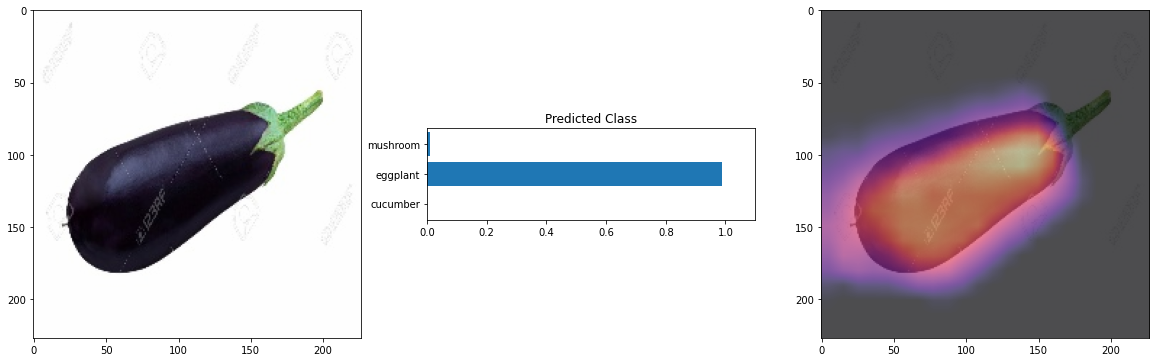

In [ ]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 34.86 MiB/s, done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-0lqyuq4x
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-0lqyuq4x
  Resolved https://github.com/albumentations-team/albumentations to commit dae3b1e75751376399379094a102a87c569bea97
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for albumentations: filename=albumentations-1.4.13-py3-none-any.whl size=171586 sha256=99fb4a5c4f7e11bd282764c6eedb30670f3f56f8012d7af0fdde31236aa09b8f
  Stored in directory: /tmp/pip-ephem-wheel-ca

# Imports

In [ ]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [ ]:
csv_file= "/content/GradCAM-Dataset/train.csv"
data_dir = "/content/GradCAM-Dataset/"

DEVICE = 'cuda'
batch_sz=16
LR=0.001
EP=20

In [ ]:
data=pd.read_csv(csv_file)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [ ]:
#cucumber -> 0 ; eggplant -> 1 ; mushroom -> 2

In [ ]:
train_df, valid_df = train_test_split(data, test_size=0.2, random_state=42)

# Augmentations

In [ ]:
train_aug = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

])

valid_aug = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Load Image Dataset

In [ ]:
trainset= utils.ImageDataset(train_df, data_dir, train_aug)
validset= utils.ImageDataset(valid_df, data_dir, valid_aug)

Image shape : torch.Size([3, 227, 227])


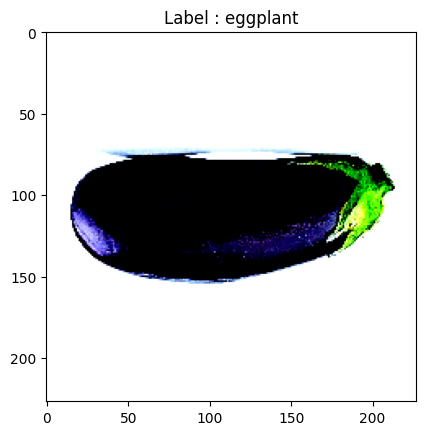

In [ ]:
image,lable= trainset[0]  #(chw) ->(hwc)

class_list=["cucumber","eggplant","mushroom"]
print(f"Image shape : {image.shape}")
plt.imshow(image.permute(1,2,0))
plt.title(f"Label : {class_list[lable]}")
plt.show()

In [ ]:
print(f"No. of examples in the trainset {len(trainset)}")
print(f"No. of examples in the validset {len(validset)}")

No. of examples in the trainset 148
No. of examples in the validset 38


# Load Dataset into Batches

In [ ]:
trainloader= DataLoader(trainset, batch_size=batch_sz, shuffle=True)
validloader= DataLoader(validset, batch_size=batch_sz, shuffle=False)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [ ]:
for images, labels in trainloader:
  break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

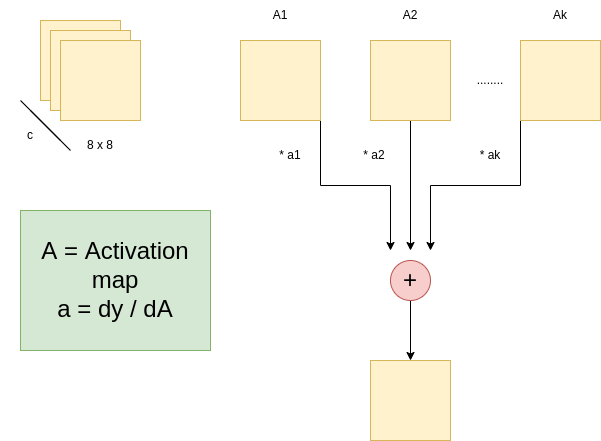

In [ ]:
class imageModel(nn.Module):
    def __init__(self):
        super(imageModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
        )
        self.MaxPool2d = nn.MaxPool2d(kernel_size=(4, 4), stride=2)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400, 2048),
            nn.ReLU(),
            nn.Linear(2048, 3),
        )
        self.gradian = None

    def activations_hook(self, grad):
        self.gradian = grad

    def get_activation_gradient(self):
        return self.gradian

    def get_activation(self, x):
        return self.feature_extractor(x)

    def forward(self, x):
        x = self.feature_extractor(x)
        h = x.register_hook(self.activations_hook)
        x = self.MaxPool2d(x)
        x = self.classifier(x)
        return x


In [ ]:
model=imageModel()
model.to(DEVICE)

imageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (MaxPool2d): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, loss_fn):
    model.train()
    total_loss=0.0
    for images,labels in tqdm(dataloader):
        images=images.to(DEVICE)
        labels=labels.to(DEVICE)

        optimizer.zero_grad()
        output=model(images)
        loss=loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()

    return total_loss/len(dataloader)

In [ ]:
def eval_fn(model, dataloader, loss_fn):
    model.eval()
    total_loss=0.0
    for images,labels in tqdm(dataloader):
        images=images.to(DEVICE)
        labels=labels.to(DEVICE)
        outputs=model(images)
        loss=loss_fn(outputs,labels)

        total_loss+=loss.item()
    return total_loss/len(dataloader)

# Training Loop

In [ ]:
optimizer= torch.optim.Adam(model.parameters(),lr=LR)
loss_fn=nn.CrossEntropyLoss()

In [ ]:
best_valid_loss= np.Inf
for epoch in range(EP):
    train_loss=train_fn(model,trainloader,optimizer,loss_fn)
    valid_loss=eval_fn(model,validloader,loss_fn)
    if valid_loss<best_valid_loss:
        best_valid_loss=valid_loss
        torch.save(model.state_dict(),"best_model.pt")

    print(f"EP: {epoch+1}, train loss:{train_loss}, valid loss: {valid_loss}")

100%|██████████| 3/3 [00:00<00:00, 44.23it/s]


EP: 1, train loss:0.15395853882655502, valid loss: 0.26437510550022125


100%|██████████| 3/3 [00:00<00:00, 43.08it/s]


EP: 2, train loss:0.07050417466089129, valid loss: 0.12372509017586708


100%|██████████| 3/3 [00:00<00:00, 43.08it/s]


EP: 3, train loss:0.1676515161525458, valid loss: 0.16427963234794637


100%|██████████| 3/3 [00:00<00:00, 44.63it/s]


EP: 4, train loss:0.1623629546491429, valid loss: 0.35040880118807155


100%|██████████| 3/3 [00:00<00:00, 40.64it/s]


EP: 5, train loss:0.06823037667199969, valid loss: 0.10604842721174161


100%|██████████| 3/3 [00:00<00:00, 36.67it/s]


EP: 6, train loss:0.14818631894886494, valid loss: 0.751632573393484


100%|██████████| 3/3 [00:00<00:00, 32.69it/s]


EP: 7, train loss:0.10624892646446824, valid loss: 0.10986169582853715


100%|██████████| 3/3 [00:00<00:00, 28.56it/s]


EP: 8, train loss:0.13182338359765708, valid loss: 0.17197076231241226


100%|██████████| 3/3 [00:00<00:00, 36.13it/s]


EP: 9, train loss:0.05933765694499016, valid loss: 0.15645001456141472


100%|██████████| 3/3 [00:00<00:00, 44.37it/s]


EP: 10, train loss:0.03719271693844348, valid loss: 0.06633384541297953


100%|██████████| 3/3 [00:00<00:00, 38.90it/s]


EP: 11, train loss:0.03217229406600382, valid loss: 0.18906209245324135


100%|██████████| 3/3 [00:00<00:00, 37.90it/s]


EP: 12, train loss:0.03991354890167713, valid loss: 0.19544965754418323


100%|██████████| 3/3 [00:00<00:00, 43.33it/s]


EP: 13, train loss:0.03441693503591523, valid loss: 0.1733815159338216


100%|██████████| 3/3 [00:00<00:00, 43.19it/s]


EP: 14, train loss:0.1636717920366209, valid loss: 0.504484336823225


100%|██████████| 3/3 [00:00<00:00, 41.55it/s]


EP: 15, train loss:0.3569988519884646, valid loss: 0.5281154612700144


100%|██████████| 3/3 [00:00<00:00, 40.97it/s]


EP: 16, train loss:0.25989400073885915, valid loss: 0.42135491967201233


100%|██████████| 3/3 [00:00<00:00, 47.04it/s]


EP: 17, train loss:0.1691995433808188, valid loss: 0.2335234135389328


100%|██████████| 3/3 [00:00<00:00, 44.37it/s]


EP: 18, train loss:0.1299040948972106, valid loss: 0.28879230717817944


100%|██████████| 3/3 [00:00<00:00, 46.83it/s]


EP: 19, train loss:0.08930497780092991, valid loss: 0.15029268835981688


100%|██████████| 3/3 [00:00<00:00, 42.07it/s]

EP: 20, train loss:0.06245911097503267, valid loss: 0.2607286816152434


# Get GradCAM

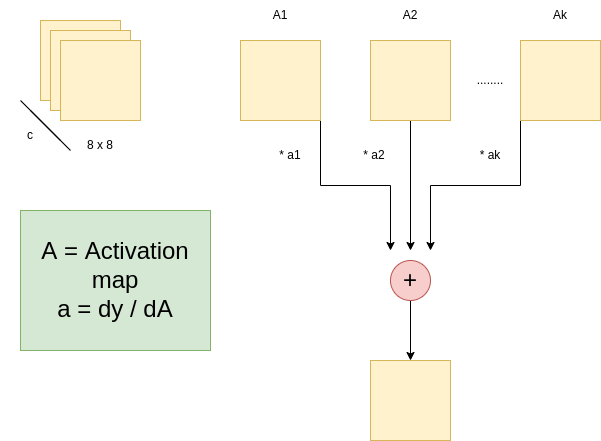

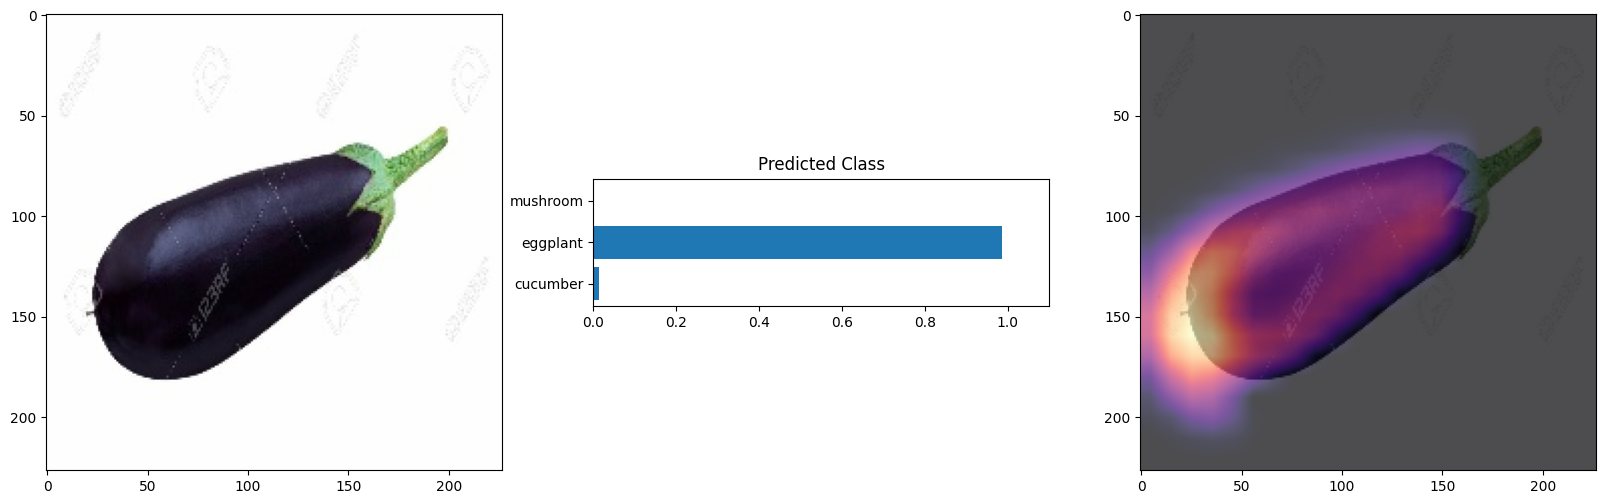

In [ ]:
import torch
import numpy as np
import cv2

def get_gradCam(model, image, label, size):
    model.eval()
    model.zero_grad()
    output = model(image)
    class_idx = label.item() if torch.is_tensor(label) else label
    target = output[:, class_idx]
    target.backward()
    gradients = model.get_activation_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activation(image).detach()

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze().cpu()
    heatmap = torch.nn.functional.relu(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (size, size))

    return heatmap

# Example usage
image, label = validset[4]
denorm_image = image.permute(1, 2, 0).numpy() * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
denorm_image = np.clip(denorm_image, 0, 1)
image = image.unsqueeze(0).to(DEVICE)
pred = model(image)
_, pred_class = torch.max(pred, 1)
heatmap = get_gradCam(model, image, pred_class, size=227)
utils.plot_heatmap(denorm_image, pred, heatmap)
